## Capstone Project - Employee Retention Prediction

**Main Steps**
1. Importing Dependencies
2. Loading Data
3. Data Exploration
4. Target Distribution
5. Exploratory Data Analysis (Feature vs Target)
6. Feature Engineering  
7. Train/Test Split
8. Identifying Numerical and Categorical Features
9. Data Preprocessing Pipeline
10. Model Definitions
11. Train and Evaluate Models (With SMOTE)
12. Performance Visualization
13. Train Best Model

## Step 1 - Importing Dependencies

- Load core Python libraries
- Load sklearn / imbalanced-learn / seaborn / matplotlib


In [7]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib


## Step 2 - Load Data

- Read dataset (aug_train.csv)
- Display shape and first rows

In [8]:

df = pd.read_csv("aug_train.csv")

print("Data shape:", df.shape)
df.head()


Data shape: (19158, 14)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Step 3 - Data Exploration

- Handle missing values

In [9]:
df.columns.tolist()

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

In [10]:
# Missing values
display(df.isnull().sum().sort_values(ascending=False))
df.info()

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
enrollee_id                  0
city                         0
relevent_experience          0
city_development_index       0
training_hours               0
target                       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## Step 4 - Target Distribution

- Visualize target distribution
- Show raw counts
- Show proportion (class imbalance overview)

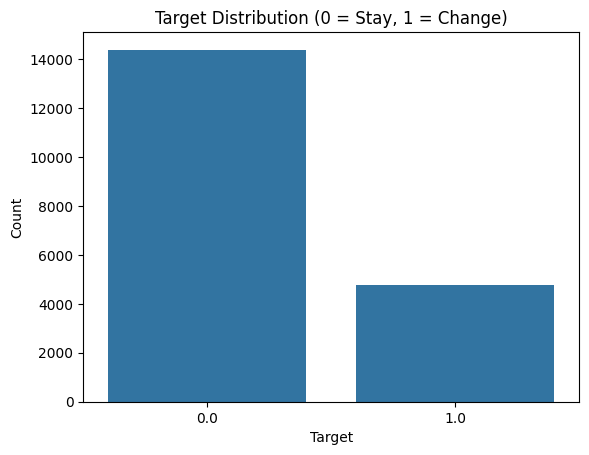

Target value counts:
target
0.0    14381
1.0     4777
Name: count, dtype: int64

Target proportion:
target
0.0    0.750652
1.0    0.249348
Name: proportion, dtype: float64


In [11]:
# === 3. TARGET DISTRIBUTION ===

target_col = "target"

sns.countplot(x=target_col, data=df)
plt.title("Target Distribution (0 = Stay, 1 = Change)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

print("Target value counts:")
print(df[target_col].value_counts())
print("\nTarget proportion:")
print(df[target_col].value_counts(normalize=True))


## Step 5 - Exploratory Data Analysis (Feature vs Target)

- Categorical Features
  - Countplots for:
    - gender
    - education_level
    - enrolled_university
    - company_type
    - experience
- Numerical Features
  - Boxplots for:
    - training_hours
    - city_development_index

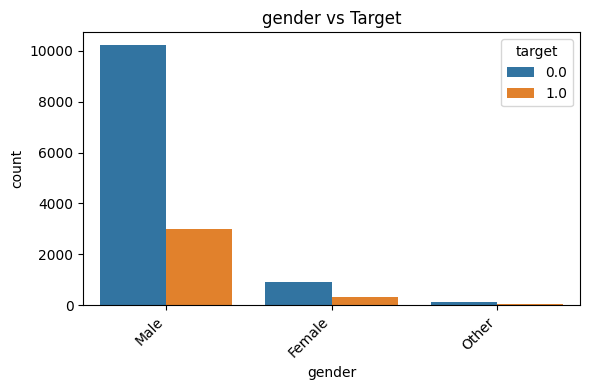

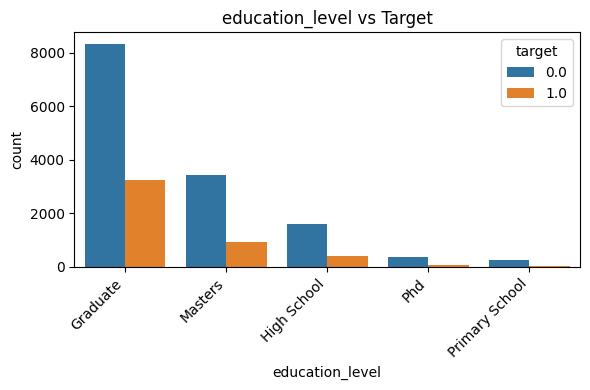

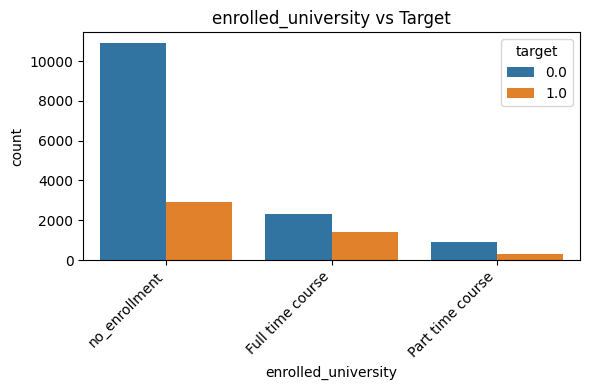

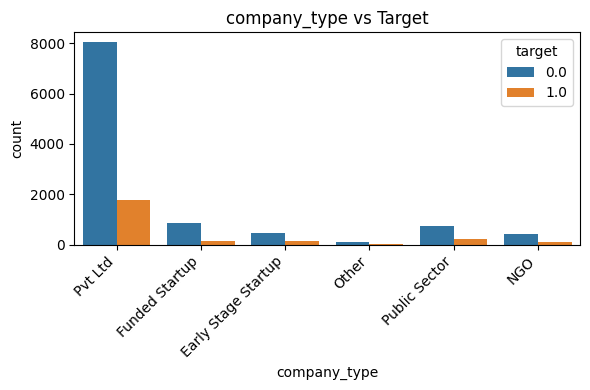

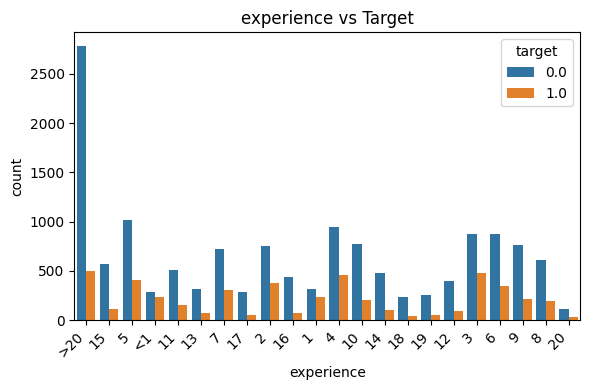

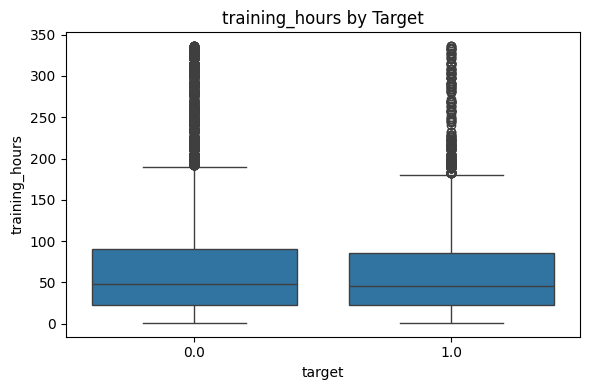

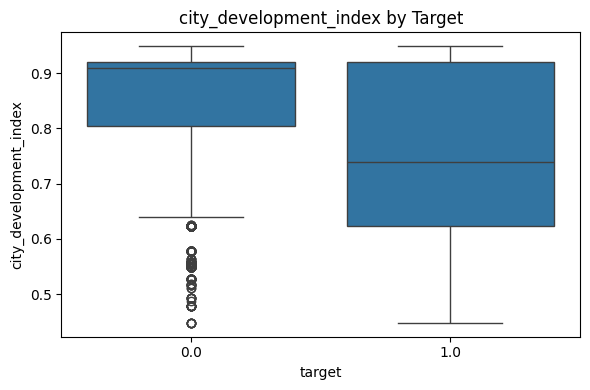

In [12]:
# Categorical vs target
cat_for_eda = ["gender", "education_level", "enrolled_university", "company_type", "experience"]

for col in cat_for_eda:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue=target_col)
        plt.title(f"{col} vs Target")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Numeric vs target
num_for_eda = ["training_hours", "city_development_index"]

for col in num_for_eda:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df, x=target_col, y=col)
        plt.title(f"{col} by Target")
        plt.tight_layout()
        plt.show()


## Step 6 - Feature Engineering 

- Clean experience column (clean_experience)
- Convert company size to numeric midpoint (clean_company_size)
- Convert last new job (clean_last_new_job)

In [13]:


def clean_experience(value):
    if pd.isna(value):
        return np.nan
    value = str(value).strip()
    if value == ">20":
        return 21
    if value == "<1":
        return 0
    try:
        return float(value)
    except ValueError:
        return np.nan

def clean_company_size(value):
    if pd.isna(value):
        return np.nan
    text = str(value).strip()

    if "-" in text:
        parts = text.split("-")
        try:
            low = int(parts[0])
            high = int(parts[1])
            return (low + high) / 2
        except Exception:
            return np.nan

    if "10000+" in text:
        return 10000

    return np.nan

def clean_last_new_job(value):
    if pd.isna(value):
        return np.nan
    text = str(value).strip()
    if text == ">4":
        return 5
    if text == "never":
        return 0
    try:
        return float(text)
    except ValueError:
        return np.nan


In [14]:

df_fe = df.copy()

if "experience" in df_fe.columns:
    df_fe["experience_years"] = df_fe["experience"].apply(clean_experience)

if "company_size" in df_fe.columns:
    df_fe["company_size_num"] = df_fe["company_size"].apply(clean_company_size)

if "last_new_job" in df_fe.columns:
    df_fe["last_new_job_num"] = df_fe["last_new_job"].apply(clean_last_new_job)

if "experience_years" in df_fe.columns and "training_hours" in df_fe.columns:
    df_fe["training_per_year"] = df_fe["training_hours"] / (
        1 + df_fe["experience_years"].fillna(0)
    )

# Buckets for experience
if "experience_years" in df_fe.columns:
    df_fe["experience_bucket"] = pd.cut(
        df_fe["experience_years"],
        bins=[-1, 1, 5, 10, 20, np.inf],
        labels=["0-1", "2-5", "6-10", "11-20", "20+"]
    )

# Buckets for city development (if present)
if "city_development_index" in df_fe.columns:
    df_fe["city_dev_bucket"] = pd.cut(
        df_fe["city_development_index"],
        bins=[0, 0.6, 0.8, 1.0],
        labels=["Low", "Medium", "High"]
    )

df_fe.head()


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,experience_years,company_size_num,last_new_job_num,training_per_year,experience_bucket,city_dev_bucket
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0,21.0,NaN,1.0,1.636364,20+,High
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,15.0,74.5,5.0,2.937500,11-20,Medium
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0,5.0,NaN,0.0,13.833333,2-5,Medium
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0,0.0,NaN,0.0,52.000000,0-1,Medium
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,21.0,74.5,4.0,0.363636,20+,Medium


## Step 7 - Train / Test Split

- Remove ID-like columns
- Define features (X) and target (y)
- Stratified split into training/testing sets

In [15]:

drop_cols = []
for col in ["enrollee_id", "id"]:
    if col in df_fe.columns:
        drop_cols.append(col)

X = df_fe.drop(columns=[target_col] + drop_cols)
y = df_fe[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (15326, 18) Test: (3832, 18)


## Step 8 - Identifying Numerical and Categorical Features 

In [16]:

numeric_features = X_train.select_dtypes(include="number").columns.tolist()
categorical_features = X_train.select_dtypes(exclude="number").columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['city_development_index', 'training_hours', 'experience_years', 'company_size_num', 'last_new_job_num', 'training_per_year']
Categorical features: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'experience_bucket', 'city_dev_bucket']


## Step 9 - Data Preprocessing Pipeline

- Numeric:
  - Median imputation
  - Standard scaling
- Categorical:
  - Constant imputation
  - One-hot encoding
- Combine using ColumnTransformer

In [17]:


numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features)
    ],
    remainder="drop"
)


## Step 10 -  Model Definitions

- Logistic Regression
- Random Forest
- XGBoost 
- LightGBM 

In [18]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

# add XGBoost
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
    print("XGBoost added.")
except ImportError:
    print("XGBoost not installed. Skipping.")

# add LightGBM
try:
    from lightgbm import LGBMClassifier
    models["LightGBM"] = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    print("LightGBM added.")
except ImportError:
    print("LightGBM not installed. Skipping.")

models


XGBoost added.
LightGBM added.


{'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1),
 'Random Forest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=-1,
               num_parallel_tree=None, ...),
 'LightGBM': LGBMClassifier(colsample_bytree=

## Step 11 - Train & Evaluate Models (With SMOTE)

- Use ImbPipeline (SMOTE → preprocessing → model)
- Train each model
- Evaluate metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-Score
  - ROC-AUC
- Create comparison table

In [19]:
results = []

for name, model in models.items():
    print(f"\nTraining model: {name}")

    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc_auc
    })

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
results_df



Training model: Logistic Regression

Training model: Random Forest

Training model: XGBoost

Training model: LightGBM
[LightGBM] [Info] Number of positive: 11504, number of negative: 11504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15226
[LightGBM] [Info] Number of data points in the train set: 23008, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.774269,0.532847,0.764398,0.627957,0.808629
2,XGBoost,0.797234,0.580909,0.669110,0.621898,0.813334
3,LightGBM,0.797234,0.583178,0.653403,0.616296,0.813131
1,Random Forest,0.787056,0.575626,0.553927,0.564568,0.808927


## Step 12 - Performance Visualization

- Select best model
- Plot confusion matrix
- Plot ROC curve


Best model based: Logistic Regression


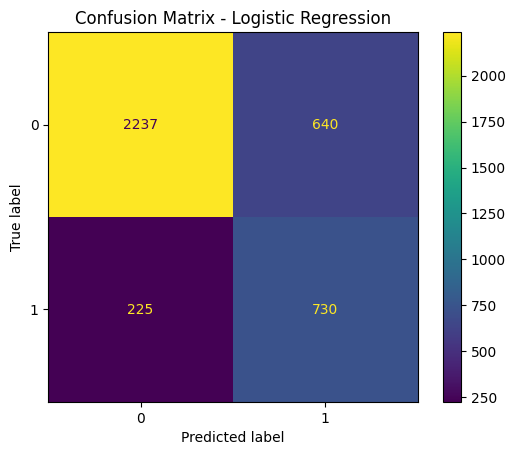

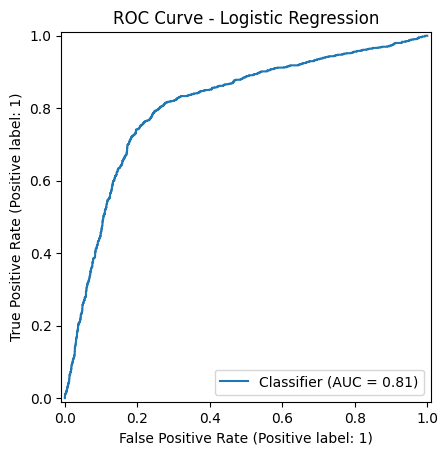

Best model ROC-AUC: 0.8086286434931675


In [20]:
# BEST MODEL: CONFUSION MATRIX & ROC CURVE 

best_row = results_df.iloc[0]
best_name = best_row["Model"]
print("Best model based:", best_name)

best_model = models[best_name]

best_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", best_model)
])

best_pipeline.fit(X_train, y_train)

y_pred_best = best_pipeline.predict(X_test)
y_proba_best = best_pipeline.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_best)
plt.title(f"ROC Curve - {best_name}")
plt.show()

print("Best model ROC-AUC:", roc_auc_score(y_test, y_proba_best))


## Step 13 - Train Best Model

- Refit best model
- Save model using joblib


In [21]:

final_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", best_model)
])

final_pipeline.fit(X, y)

joblib.dump(final_pipeline, "best_employee_retention_model.joblib")
print("Model saved as best_employee_retention_model.joblib")


Model saved as best_employee_retention_model.joblib


## Step 14 - Dashboard Dataset

In [22]:


dashboard_df = df_fe.copy()
dashboard_df.to_csv("dashboard_dataset.csv", index=False)
print("Saved dashboard_dataset.csv")


Saved dashboard_dataset.csv
